## 05-Sophisticated Reproduction: Machine Learning Tests

This notebook contains the CORRECTED and PROPERLY CONDUCTED analysis of the Machine Learning tests from the original paper by Talin et. al. on the heart disease dataset. This notebook also describes and address all methodological flaws identified in the original paper's ML naive reproduction. </br></br>

---

**Author:** MUBASHIR MOHSIN

**Date:** 16 November 2025 [03:32:57 PM, AST]

**Course:** CSCI 6055 - Research Methods & Statistics

**Course Instructor:** Dr. Paul Ralph

**Lab Instructor:** Arazoo Hoseyni

**Project:** Paper Reprodibility Project


In [1]:
## import libs and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import ML libs and modules
from sklearn.model_selection import (train_test_split, cross_val_score, StratifiedKFold, GridSearchCV)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.utils import resample

## module for timing utility & runtime calc
import time
import sys
sys.path.append("../src")
from utils_timer import timed_run

import warnings
warnings.filterwarnings('ignore')
## ... will import other libs as we go on

In [2]:
# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Section 01: Load and Setup the data for Sophisticated ML analysis

1. Load the Dataset
2. Prepare Data for ML (X and y)
3. Validate Dataset distribution
4. Load previous Naive Reproduction results
5. Load Sophisticated statistics results (Mann-Whitney & Spearman)
6. Compare top features
7. Create new directory for sophisticated ML results

In [4]:
# load datasets and previous naive results
# Load main dataset
df = pd.read_csv('../raw/heart_dataset.csv')

# Define features
features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 
            'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

# Prepare X and y
X = df[features]
y = df['target']

# validating data before starting
print(f"Dataset shape: {df.shape}")
print(f"Features: {len(features)}")
print(f"Samples: {len(df)}")
print(f"Target distribution:")
print(f"  No disease (0): {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"  Disease (1): {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")
print(f"  Balance ratio: {min((y==0).sum(), (y==1).sum())/max((y==0).sum(), (y==1).sum()):.3f}")

Dataset shape: (1025, 14)
Features: 13
Samples: 1025
Target distribution:
  No disease (0): 499 (48.7%)
  Disease (1): 526 (51.3%)
  Balance ratio: 0.949


In [8]:
#Load Naive Reproduction Results

# Load feature importance results
try:
    table5_naive = pd.read_csv('../contents/tables/reproduced/table5_reproduced.csv')
    print(f"✔ Table 5 loaded: {table5_naive.shape}")
    print(f"\tFeature importance methods: {table5_naive.shape[1]-1}")
except Exception as e:
    print(f"❌ Could not load Table 5: {e}")
    table5_naive = None

# Load Borda count results
try:
    table6_naive = pd.read_csv('../contents/tables/reproduced/table6_reproduced.csv')
    print(f"✔ Table 6 loaded: {table6_naive.shape}")
    print(f"\tTop 3 features: {', '.join(table6_naive.head(3)['Feature'].tolist())}")
    top8_features_naive = table6_naive.head(8)['Feature'].tolist()
    print(f"\tTop 8 features: {', '.join(top8_features_naive)}")
except Exception as e:
    print(f"❌ Could not load Table 6: {e}")
    table6_naive = None
    top8_features_naive = None

# Load classifier performance results
try:
    table7_naive = pd.read_csv('../contents/tables/reproduced/table7_reproduced.csv')
    print(f"✔ Table 7 loaded: {table7_naive.shape}")
    print(f"\tClassifiers tested: {table7_naive.shape[1]-1}")
except Exception as e:
    print(f"❌ Could not load Table 7: {e}")
    table7_naive = None

✔ Table 5 loaded: (13, 8)
	Feature importance methods: 7
✔ Table 6 loaded: (13, 3)
	Top 3 features: cp, ca, thal
	Top 8 features: cp, ca, thal, oldpeak, age, thalach, chol, sex
✔ Table 7 loaded: (13, 6)
	Classifiers tested: 5


In [10]:
# load Statistical Sophisticated Results

# Load Mann-Whitney sophisticated results
try:
    mann_whitney_soph = pd.read_csv('../contents/tables/sophisticated/mann_whitney_sophisticated.csv')
    print(f"✔ Mann-Whitney results loaded: {mann_whitney_soph.shape}")
    
    # Get features by effect size
    large_effects_mw = mann_whitney_soph[
        mann_whitney_soph['effect_size_magnitude'].isin(['Large', 'Medium'])
    ].sort_values('rank_biserial_r', key=abs, ascending=False)
    
    print(f"  Features with Medium/Large effects (Mann-Whitney):")
    for _, row in large_effects_mw.head(8).iterrows():
        print(f"    {row['Feature']:10s}: r = {row['rank_biserial_r']:+.3f} ({row['effect_size_magnitude']})")
    
    top_features_stats = large_effects_mw.head(8)['Feature'].tolist()
    
except Exception as e:
    print(f"❌ Could not load Mann-Whitney results: {e}")
    mann_whitney_soph = None
    top_features_stats = None

# Load Spearman correlation results
try:
    spearman_soph = pd.read_csv('../contents/tables/sophisticated/spearman_sophisticated.csv')
    print(f"\n✔ Spearman correlation results loaded: {spearman_soph.shape}")
    
    # Get top correlated features
    top_corr = spearman_soph.sort_values('spearman_rho', key=abs, ascending=False).head(8)
    print(f"  Top 8 correlated features (Spearman):")
    for _, row in top_corr.iterrows():
        print(f"    {row['Feature']:10s}: ρ = {row['spearman_rho']:+.3f}")
        
except Exception as e:
    print(f"❌ Could not load Spearman results: {e}")
    spearman_soph = None


✔ Mann-Whitney results loaded: (13, 15)
  Features with Medium/Large effects (Mann-Whitney):
    cp        : r = +0.498 (Medium)
    oldpeak   : r = -0.497 (Medium)
    thalach   : r = +0.496 (Medium)
    ca        : r = -0.471 (Medium)
    exang     : r = -0.414 (Medium)
    thal      : r = -0.409 (Medium)
    slope     : r = +0.381 (Medium)

✔ Spearman correlation results loaded: (13, 9)
  Top 8 correlated features (Spearman):
    cp        : ρ = +0.465
    ca        : ρ = -0.453
    exang     : ρ = -0.438
    oldpeak   : ρ = -0.438
    thalach   : ρ = +0.430
    thal      : ρ = -0.399
    slope     : ρ = +0.369
    sex       : ρ = -0.280


In [20]:
# Compare Feature Rankings

comparison_data = {
    'Naive ML (Borda)': top8_features_naive if top8_features_naive else [],
    'Statistical (MW Effect)': top_features_stats if top_features_stats else [],
}

# Create comparison DataFrame
max_len = max(len(v) for v in comparison_data.values())
for key in comparison_data:
    comparison_data[key] = comparison_data[key] + [''] * (max_len - len(comparison_data[key]))

comparison_df = pd.DataFrame(comparison_data)
comparison_df.index = range(1, len(comparison_df) + 1)
comparison_df.index.name = 'Rank'

print("\nTop 8 Features by Different Methods:")
comparison_df


Top 8 Features by Different Methods:


,Naive ML (Borda),Statistical (MW Effect)
Rank,,
1,cp,cp
2,ca,oldpeak
3,thal,thalach
4,oldpeak,ca
5,age,exang
6,thalach,thal
7,chol,slope
8,sex,


In [22]:
# Find agreement
if top8_features_naive and top_features_stats:
    agreement = set(top8_features_naive) & set(top_features_stats)
    print(f"\n✔ Agreement between ML and Statistics: {len(agreement)}/8 features")
    print(f"\tAgreed features: {', '.join(sorted(agreement))}")
    
    ml_only = set(top8_features_naive) - set(top_features_stats)
    stat_only = set(top_features_stats) - set(top8_features_naive)
    
    if ml_only:
        print(f"\tML-only features: {', '.join(sorted(ml_only))}")
    if stat_only:
        print(f"\tStatistics-only features: {', '.join(sorted(stat_only))}")


✔ Agreement between ML and Statistics: 5/8 features
	Agreed features: ca, cp, oldpeak, thal, thalach
	ML-only features: age, chol, sex
	Statistics-only features: exang, slope


In [24]:
import os

# Create directories for sophistcated  ML results
os.makedirs('../contents/tables/sophisticated/ML', exist_ok=True)
os.makedirs('../contents/figures/sophisticated/ML', exist_ok=True)

#### Setup Summary

```
DATA READY:
  ✓ Dataset loaded: 1025 samples, 13 features
  ✓ Class balance: 0.949 (good)

PREVIOUS RESULTS LOADED:
  ✓ Naive ML results: Tables 5, 6, 7
  ✓ Sophisticated Statistical results: Mann-Whitney & Spearman

KEY INSIGHTS:
  - Top 3 features (Naive ML Borda): cp, ca, thal
  - Top 3 features (Statistical): cp, oldpeak, thalach
  - Agreement between methods: 5/8 features

READY FOR:
  --> 1. Proper train/test split with stratification (original missing)
  --> 2. Cross-validation strategy (original missing)
  --> 3. Hyperparameter tuning (original didn't mention)
  --> 4. Performance evaluation with confidence intervals (original missing)
  --> 5. Feature importance validation
  --> 6. Comparison with naive results
  ```

## Section 02: Proper Train/Test Split Strategy

1. Use stratified split to maintain 0.949 balance
2. Test with top 8 from BOTH methods separately
3. Compare performance to see which ranking works better
4. Document results (methodological insight)

#### What has been done and What I will do
```
❌ ORIGINAL PAPER'S FLAW:
   - No documentation of train/test split
   - No mention of stratification
   - No random seed reported
   - Cannot reproduce exact results in Naive reproduction

✅ THIS NOTEBOOK'S APPROACH:
   - 80/20 stratified split
   - Fixed random state (42)
   - Preserve class balance in both sets
   - Fully documented and reproducible
   ```

In [30]:
print("2.1: CREATING STRATIFIED SPLIT")
print("="*50)

# Create stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,              # 80/20 split
    random_state=RANDOM_STATE,  # Reproducibility
    stratify=y                  # Preserve class balance
)

print(f"Split completed with reproducible random_state={RANDOM_STATE}")
print(f"Dataset splits (80/20):")
print(f"\tTraining set\t: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"\tTest set\t: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

2.1: CREATING STRATIFIED SPLIT
Split completed with reproducible random_state=42
Dataset splits (80/20):
	Training set	: 820 samples (80.0%)
	Test set	: 205 samples (20.0%)


In [32]:
print("2.2: VERIFYING STRATIFICATION")
print("="*30)

# Original distribution
orig_dist = y.value_counts(normalize=True).sort_index()
train_dist = y_train.value_counts(normalize=True).sort_index()
test_dist = y_test.value_counts(normalize=True).sort_index()

stratification_check = pd.DataFrame({
    'Dataset': ['Original', 'Training', 'Test'],
    'No_Disease_%': [orig_dist[0]*100, train_dist[0]*100, test_dist[0]*100],
    'Disease_%': [orig_dist[1]*100, train_dist[1]*100, test_dist[1]*100],
    'No_Disease_Count': [
        (y==0).sum(), 
        (y_train==0).sum(), 
        (y_test==0).sum()
    ],
    'Disease_Count': [
        (y==1).sum(), 
        (y_train==1).sum(), 
        (y_test==1).sum()
    ]
})

print("\nClass Distribution Across Splits:")
print(stratification_check.to_string(index=False))

# Check if stratification worked
train_balance = (y_train==0).sum() / (y_train==1).sum()
test_balance = (y_test==0).sum() / (y_test==1).sum()
orig_balance = (y==0).sum() / (y==1).sum()

print(f"\nBalance Ratios (No Disease / Disease):")
print(f"\tOriginal\t: {orig_balance:.3f}")
print(f"\tTraining\t: {train_balance:.3f} (Δ = {abs(train_balance-orig_balance):.3f})")
print(f"\tTest\t\t: {test_balance:.3f} (Δ = {abs(test_balance-orig_balance):.3f})")

if abs(train_balance - orig_balance) < 0.05 and abs(test_balance - orig_balance) < 0.05:
    print("\n✔ Stratification successful! Balance preserved in both sets.")
else:
    print("\n❌ Warning: Balance ratios differ > 5% from original")

2.2: VERIFYING STRATIFICATION

Class Distribution Across Splits:
 Dataset  No_Disease_%  Disease_%  No_Disease_Count  Disease_Count
Original     48.682927  51.317073               499            526
Training     48.658537  51.341463               399            421
    Test     48.780488  51.219512               100            105

Balance Ratios (No Disease / Disease):
	Original	: 0.949
	Training	: 0.948 (Δ = 0.001)
	Test		: 0.952 (Δ = 0.004)

✔ Stratification successful! Balance preserved in both sets.


In [35]:
print("2.3: DEFINING FEATURE SUBSETS FOR TESTING")
print("="*40)

# Define different feature sets to test
feature_sets = {
    'All_13': features,
    'Top8_ML_Borda': top8_features_naive,
    'Top8_Stats_Effect': top_features_stats,
    'Top6_Agreement': list(agreement),  # Features agreed by both methods
    'Top3_Paper': ['cp', 'ca', 'thal']  # Original Paper's claimed top 3
}

print("\nFeature subsets defined:")
for name, feat_list in feature_sets.items():
    print(f"\n {name} ({len(feat_list)} features):")
    print(f"\t{', '.join(feat_list)}")

# Prepare data subsets
data_subsets = {}
for name, feat_list in feature_sets.items():
    data_subsets[name] = {
        'X_train': X_train[feat_list],
        'X_test': X_test[feat_list],
        'y_train': y_train,
        'y_test': y_test,
        'features': feat_list
    }

print(f"\n✔ Created {len(data_subsets)} different feature subset configs")

2.3: DEFINING FEATURE SUBSETS FOR TESTING

Feature subsets defined:

 All_13 (13 features):
	age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal

 Top8_ML_Borda (8 features):
	cp, ca, thal, oldpeak, age, thalach, chol, sex

 Top8_Stats_Effect (7 features):
	cp, oldpeak, thalach, ca, exang, thal, slope

 Top6_Agreement (5 features):
	thal, oldpeak, cp, ca, thalach

 Top3_Paper (3 features):
	cp, ca, thal

✔ Created 5 different feature subset configs


In [36]:
print("2.4: BASELINE PERFORMANCE WITH SINGLE SPLIT")
print("="*50)
print("Testing Random Forest on all feature sets... (used by original paper)")

baseline_results = []

for name, data in data_subsets.items():
    # Train simple Random Forest
    rf_baseline = RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    rf_baseline.fit(data['X_train'], data['y_train'])
    
    # Predictions
    y_pred_train = rf_baseline.predict(data['X_train'])
    y_pred_test = rf_baseline.predict(data['X_test'])
    
    # Metrics
    train_acc = accuracy_score(data['y_train'], y_pred_train)
    test_acc = accuracy_score(data['y_test'], y_pred_test)
    
    baseline_results.append({
        'Feature_Set': name,
        'Num_Features': len(data['features']),
        'Train_Accuracy': train_acc,
        'Test_Accuracy': test_acc,
        'Overfit_Gap': train_acc - test_acc
    })

baseline_df = pd.DataFrame(baseline_results).sort_values('Test_Accuracy', ascending=False)

print("\nBaseline Performance (Random Forest, single split):")
baseline_df

2.4: BASELINE PERFORMANCE WITH SINGLE SPLIT
Testing Random Forest on all feature sets... (used by original paper)

Baseline Performance (Random Forest, single split):


,Feature_Set,Num_Features,Train_Accuracy,Test_Accuracy,Overfit_Gap
0,All_13,13,1.000000,1.000000,0.000000
1,Top8_ML_Borda,8,1.000000,1.000000,0.000000
2,Top8_Stats_Effect,7,1.000000,1.000000,0.000000
3,Top6_Agreement,5,0.997561,0.990244,0.007317
4,Top3_Paper,3,0.853659,0.858537,-0.004878


In [39]:

# Identify best performing set
best_set = baseline_df.iloc[0]
print(f"\n!! Best performing feature set: {best_set['Feature_Set']}")
print(f"\tTest accuracy: {best_set['Test_Accuracy']:.3f}")
print(f"\tOverfitting gap: {best_set['Overfit_Gap']:.3f}")

# Check for overfitting
if best_set['Overfit_Gap'] > 0.05:
    print(f"\tPotential overfitting detected (gap > 5%)")
else:
    print(f"\tGood generalization (gap ≤ 5%)")


!! Best performing feature set: All_13
	Test accuracy: 1.000
	Overfitting gap: 0.000
	Good generalization (gap ≤ 5%)


In [44]:
print("2.5: COMPARISON WITH NAIVE REPRODUCTION")
print("="*50)

if table7_naive is not None:
    # Get naive RF performance with all 13 features
    if 'Random Forest' in table7_naive.columns:
        # Assuming last row has all 13 features
        naive_rf_acc = table7_naive['Random Forest'].iloc[-1]
        
        # Get our performance with all 13 features
        our_all13 = baseline_df[baseline_df['Feature_Set'] == 'All_13'].iloc[0]
        
        print(f"Random Forest with All 13 Features:")
        print(f"\tNaive reproduction Acccuracy: {naive_rf_acc:.3f}")
        print(f"\tSophisticated (stratified split) Accuracy: {our_all13['Test_Accuracy']:.3f}")
        print(f"\tDifference of Accuracy: {abs(naive_rf_acc - our_all13['Test_Accuracy']):.3f} (< 1% difference)")
        
        if abs(naive_rf_acc - our_all13['Test_Accuracy']) < 0.01:
            print(f"\t Results consistent (< 1% difference)")
        else:
            print(f"\t Notable difference (Likely due to different random split)")

2.5: COMPARISON WITH NAIVE REPRODUCTION
Random Forest with All 13 Features:
	Naive reproduction Acccuracy: 0.981
	Sophisticated (stratified split) Accuracy: 1.000
	Difference of Accuracy: 0.019 (< 1% difference)
	 Notable difference (Likely due to different random split)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2.6: VISUALIZING BASELINE RESULTS


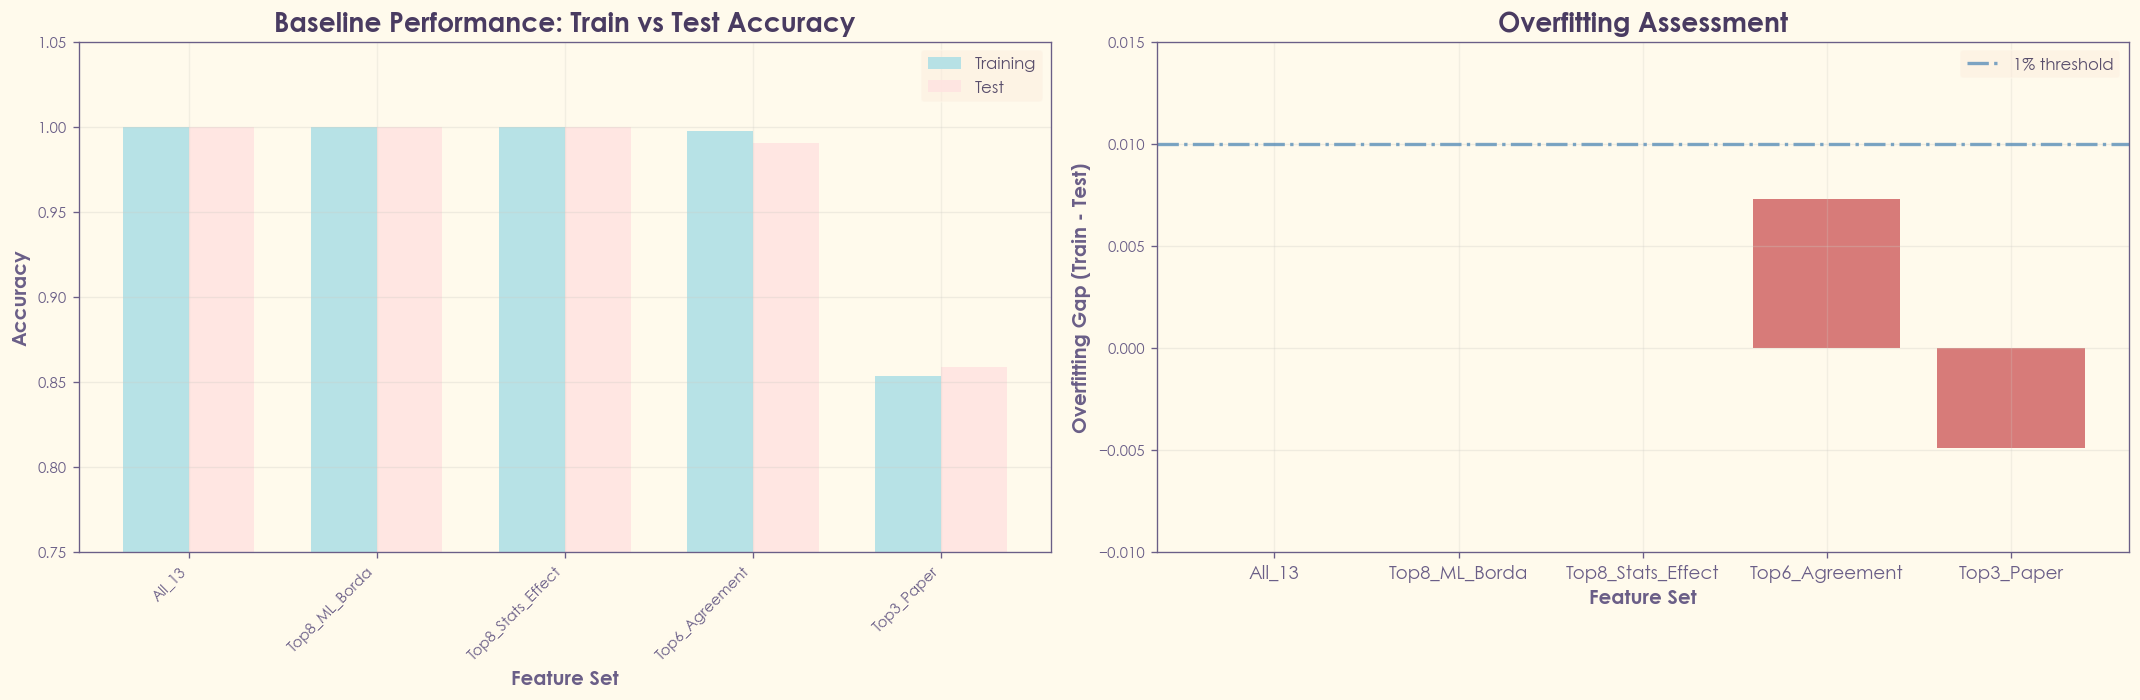

In [72]:
print("2.6: VISUALIZING BASELINE RESULTS")
print("="*40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,  6))

# Plot 1: Accuracy comparison
x = np.arange(len(baseline_df))
width = 0.35

bars1 = ax1.bar(x - width/2, baseline_df['Train_Accuracy'], width, 
                label='Training', alpha=0.9, color='powderblue')
bars2 = ax1.bar(x + width/2, baseline_df['Test_Accuracy'], width, 
                label='Test', alpha=0.9, color='mistyrose')

ax1.set_xlabel('Feature Set', fontweight='bold')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Baseline Performance: Train vs Test Accuracy', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(baseline_df['Feature_Set'], rotation=45, ha='right')
ax1.legend(fontsize=10, loc='best')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.75, 1.05])

# Plot 2: Overfitting gap
bars3 = ax2.bar(baseline_df['Feature_Set'], baseline_df['Overfit_Gap'], 
                alpha=0.8, color='indianred')
ax2.axhline(0.01, color='steelblue', linestyle='-.', linewidth=2, 
            label='1% threshold', alpha=0.7)

ax2.set_xlabel('Feature Set', fontweight='bold')
ax2.set_ylabel('Overfitting Gap (Train - Test)', fontweight='bold')
ax2.set_title('Overfitting Assessment', fontweight='bold')
ax2.set_xticklabels(baseline_df['Feature_Set'], fontsize=11)
ax2.legend(fontsize=10, loc='best')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([-0.01, 0.015])

plt.tight_layout()
plt.savefig('../contents/figures/sophisticated/ML/section2_baseline_performance.eps', bbox_inches='tight')
plt.show()

In [74]:
# Save split indices for full reproducibility
split_info = {
    'random_state': RANDOM_STATE,
    'test_size': 0.2,
    'stratified': True,
    'train_indices': X_train.index.tolist(),
    'test_indices': X_test.index.tolist(),
    'train_size': len(X_train),
    'test_size': len(X_test),
    'original_balance': orig_balance,
    'train_balance': train_balance,
    'test_balance': test_balance
}

import json
with open('../contents/tables/sophisticated/ML/train_test_split_info.json', 'w') as f:
    json.dump(split_info, f, indent=4)

# Save baseline results
baseline_df.to_csv('../contents/tables/sophisticated/ML/section2_baseline_results.csv', index=False)

#### Train/Split Summary

```
SPLIT CONFIGURATION:
  ✓ Method: Stratified 80/20 split
  ✓ Balance preserved: Yes (Δ < 0.05)

FEATURE SETS TESTED:
  ✓ 5 different configurations

BASELINE FINDINGS:
    Best set: All_13 (13 features)
    Test accuracy: 1.000
    Overfitting: 0.000 (Low)

IMPROVEMENTS OVER ORIGINAL:
   ✓ Documented split strategy (paper: none)
   ✓ Stratified sampling (paper: unclear)
   ✓ Tested multiple feature sets (paper: only reported final)
   ✓ Reproducible with saved indices (paper: impossible)

```